In [1]:
import pandas as pd
from urlparse import urlparse
import tldextract
from collections import Counter
import numpy as np
from time import time
import math

In [2]:
df = pd.read_csv('../data/raw/solr-dsi-domain_only-04-28-2017-cleaned.csv')

In [3]:
df = df.dropna(subset =['title'])
df = df.dropna(subset =['content'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 524062 entries, 0 to 524061
Data columns (total 12 columns):
_version_    524062 non-null int64
cache        11882 non-null object
segment      524062 non-null int64
digest       524062 non-null object
tstamp       524062 non-null object
url          524062 non-null object
anchor       45801 non-null object
content      524062 non-null object
id           524062 non-null object
title        524062 non-null object
boost        524062 non-null float64
domain       524062 non-null object
dtypes: float64(1), int64(2), object(9)
memory usage: 52.0+ MB


In [5]:
from sklearn.feature_extraction import stop_words

In [6]:
dsi_stop_words = ['the', 'blog', 'i', 'in', 'new', 'use', 'a', 'how', 'it', 'like', 'need', 'sign', 'for', 
                  'rss', 'videos', 'view', 'using', 'interview', 'follow', 'read', 'make', 'video',
                  'post', 'comment', 'comments', 'subscribe', 'things', 'just', 'add', 'wise', 'know', 'upcoming', 
                  'people', 'practitioner', 'used', 'developers', 'events', 'companies', 'better', 'terms', 'time',
                  'customer', 'conference', 'tags', 'contact', 'years', 'type', 'value', 'march', 'best', 'does',
                 'live', 'cases', 'way', 'privacy']

In [7]:
import re
def dsi_title_letters_removal(x):
    s = re.sub('[^a-zA-Z]+', '', x)
    if(len(s) > 0):
        s = s.strip().lower()
        if s not in stop_words.ENGLISH_STOP_WORDS and s not in dsi_stop_words:
            return s
        else:
            return None
    return None

In [8]:
def filter_csi(x):
    s = x.split()
    r = [t for t in s if (t.strip()) > 0 and t.strip() not in stop_words]
    t = ' '.join(r)
    return t
    #ret = classifier_filters(t)

In [9]:
def map_word2vec_centroid(x):
    global word2vec_model
    x = x.items() #dict to tuple
    # remove out-of-vocabulary words
    doc = [(word, fq) for word, fq in x if word in word2vec_model.wv.vocab]   
    if len(doc) == 0:
        #print x
        return None
    #words, fq = zip(*doc)
    ret = [word2vec_model[x] * y for x, y in doc]
    
    val = np.mean(ret, axis=0)
    #print ret
    
    #doc = [word for word in doc if word in word2vec_model.vocab]
    return val

In [10]:
from gensim.models import Word2Vec, KeyedVectors
global word2vec_model
word2vec_model = Word2Vec.load('../Words_Embedding/dsi_model_v3.bin')

In [11]:
def map_words_fq(x):
    s = x.split()
    ret = [dsi_title_letters_removal(item) for item in s if dsi_title_letters_removal(item) != None]
    count = Counter(ret)
    top_N = count.most_common(100)
    if len(top_N) > 0:
        words, cnt = zip(*top_N)
        tot = sum(cnt)
        dsi_fq = [float(i)*1.0/tot for i in cnt]
        dictionary = dict(zip(words, dsi_fq))
        #print ret
        return dictionary
    else:
        return None

In [12]:
t0 = time()
df['words_fq'] = df.content.map(lambda x: map_words_fq(x))
time() - t0

1595.6897780895233

In [14]:
df = df.dropna(subset =['words_fq'])

In [15]:
t0 = time()
df['w2v_centroid'] = df.words_fq.map(lambda x: map_word2vec_centroid(x))
time() - t0

179.04671692848206

In [16]:
df = df.dropna(subset =['w2v_centroid'])

In [17]:
articles = df['content']

In [18]:
articles_split = [re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', item) for item in articles]

In [19]:
sentences = [item for sublist in articles_split for item in sublist]

In [20]:
count = Counter(sentences)

In [21]:
sen = count.keys()

In [22]:
sentences_counted = [item for item in sen if len(item.split()) > 1]

In [23]:
words = [item.split() for item in sentences_counted]

In [24]:
from sklearn.feature_extraction import stop_words

In [25]:
dsi_stop_words = ['the', 'new', 'i', 'in', 'contact', 'use', 'home', 'about', 'us', 'a', 'it', 'this', 'blog'
                 'more', 'l', 'all', 'for', 'using', 'like', 'sign', 'view', 'web', 'best', 'how', 'support',
                 'help', 'marketing', 'you', 'we', 'need', 'time', 'university', 'social', 'content', 'online',
                 'media', 'post', 'service', 'program', 'work', 'video', 'people', 'email', 'comments', 'resources',
                 'read', 'company', 'google', 'open', 'customer', 'mobile']

In [26]:
import re
def dsi_title_letters_removal(x):
    s = re.sub('[^a-zA-Z]+', '', x)
    if(len(s) > 0):
        s = s.strip().lower()
        if s not in stop_words.ENGLISH_STOP_WORDS and s not in dsi_stop_words:
            return s
        else:
            return None
    return None

In [27]:
t0 = time()
flatten = [dsi_title_letters_removal(item) for sublist in words for item in sublist if dsi_title_letters_removal(item) != None ]
time() - t0

1127.586175918579

In [28]:
count = Counter(flatten)

In [29]:
top_N = count.most_common(100)

In [73]:
dsi_words, cnt = zip(*top_N)
tot = sum(cnt)
dsi_fq = [float(i)*1.0/tot for i in cnt]
dsi_dict = dict(zip(dsi_words, dsi_fq))

for i in range(0, 100):
    print dsi_words[i], dsi_fq[i]

data 0.0969650032206
analytics 0.0280962130274
business 0.0276695310929
information 0.0231879223793
big 0.0216697423891
news 0.0205985645493
search 0.0197588326909
research 0.0196494358052
management 0.0192498048918
science 0.0191447106095
services 0.016533115562
software 0.0147030607272
learning 0.0139554301411
technology 0.0137616425891
blog 0.0126072242841
events 0.0125044730035
security 0.0120914656797
share 0.0114752987966
cloud 0.0113932511323
market 0.0107044511923
twitter 0.0106444277452
page 0.0104514495939
systems 0.0103362591036
internet 0.00978918947472
free 0.00948102083312
analysis 0.0094673462224
development 0.00887903976117
world 0.00880832370573
make 0.00862940356545
used 0.00845440262825
students 0.00845150582598
edit 0.00843007800918
sales 0.00814896038878
center 0.00808889434169
facebook 0.00808391013779
tools 0.00790835540015
la 0.00775410067921
s 0.00762544857835
industry 0.00757351913764
march 0.00755647912428
ibm 0.0075475757173
machine 0.00753534950771
global 0

In [31]:
def map_word2vec_centroid(x):
    global word2vec_model
    x = x.items() #dict to tuple
    # remove out-of-vocabulary words
    doc = [(word, fq) for word, fq in x if word in word2vec_model.wv.vocab]   
    if len(doc) == 0:
        #print x
        return None
    #words, fq = zip(*doc)
    ret = [word2vec_model[x] * y for x, y in doc]
    
    val = np.mean(ret, axis=0)
    #print ret
    
    #doc = [word for word in doc if word in word2vec_model.vocab]
    return val

In [32]:
dsi_centroid = map_word2vec_centroid(dsi_dict)

In [74]:
dsi_centroid

array([  5.57587598e-04,  -1.79459024e-02,   7.04535935e-03,
         1.43340882e-02,  -7.76140252e-03,   3.43503524e-03,
         1.66115388e-02,   7.65618356e-03,  -3.81372240e-03,
         5.10195224e-03,   3.16925958e-04,  -7.58588139e-05,
        -6.08161883e-03,  -1.01832282e-02,   8.43714923e-03,
         1.29855648e-02,   1.45062357e-02,  -1.07757151e-02,
         3.52232647e-03,  -1.66035502e-03,   1.21895894e-02,
         1.86585030e-03,   2.75558932e-03,  -6.53199758e-03,
         1.38446561e-03,  -5.41030010e-03,   3.87368491e-03,
         1.57983284e-02,  -1.45087251e-02,   3.19889747e-03,
         7.22100679e-03,   1.03790290e-03,  -2.17707886e-04,
        -7.28191528e-03,   4.05210303e-03,   1.67787087e-03,
        -2.31346837e-03,   2.53009307e-03,  -1.94130477e-03,
         4.25886875e-03,   1.84244160e-02,  -1.43694887e-02,
         6.70837006e-03,   1.08291628e-02,   2.75860634e-03,
        -1.21162264e-02,  -8.67650378e-03,   4.39964049e-03,
        -7.34082935e-03,

In [33]:
def get_cosine2(vec1, vec2):
    
    sum1 = np.sum([vec1**2])
    sum2 = np.sum([vec2**2])
    numerator = np.sum([a*b for a,b in zip(vec1,vec2)])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

In [34]:
df['check_sim'] = df.w2v_centroid.map(lambda x:get_cosine2(x, dsi_centroid))

In [35]:
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline 

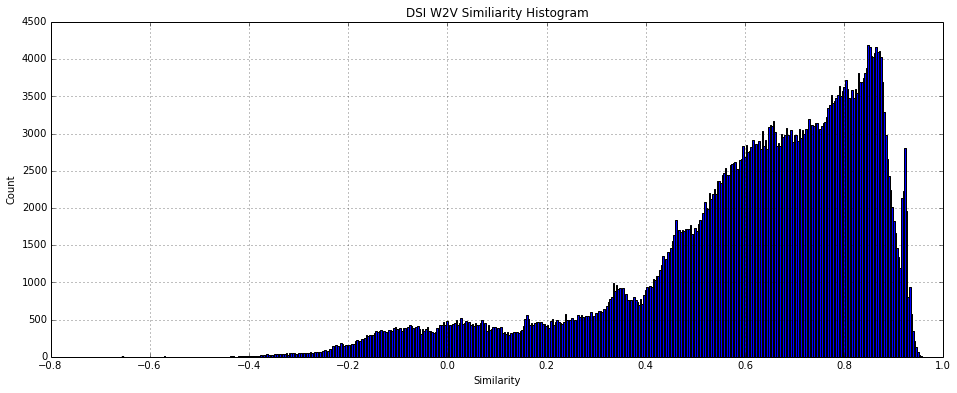

In [36]:
df['check_sim'].hist(bins=500, figsize= (16, 6))
plt.title('DSI W2V Similiarity Histogram')
plt.xlabel('Similarity')
plt.ylabel('Count')

In [98]:
msk = df['check_sim'] > 0.92
check = df[msk]
msk = check['check_sim'] < 1 
check = check[msk]
msk = check['content_len'] > 2000 
check = check[msk]

In [99]:
check.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4102 entries, 611 to 522411
Data columns (total 16 columns):
_version_       4102 non-null int64
cache           2 non-null object
segment         4102 non-null int64
digest          4102 non-null object
tstamp          4102 non-null object
url             4102 non-null object
anchor          196 non-null object
content         4102 non-null object
id              4102 non-null object
title           4102 non-null object
boost           4102 non-null float64
domain          4102 non-null object
words_fq        4102 non-null object
w2v_centroid    4102 non-null object
check_sim       4102 non-null float64
content_len     4102 non-null int64
dtypes: float64(2), int64(3), object(11)
memory usage: 544.8+ KB


In [100]:
df['content_len'] = df['content'].str.len()

In [102]:
for i in range(1, 2000):
    print i, check.iloc[i]['content_len'], check.iloc[i]['title'], check.iloc[i]['check_sim']
    print check.iloc[i]['content']
    print '--------'

1 2840 SmartBite | The Benefits of Data Prep for Hadoop 0.932617643576
SmartBite | The Benefits of Data Prep for Hadoop Menu SmartBite | 6/11/2015 The Benefits of Data Prep for Hadoop Failing to prepare is preparing to fail. Prepping diverse data in Hadoop for analysis is a valuable capability that contributes to more comprehensive and robust engagement of business information. Aberdeen Group's 2015 Business Analytics survey identified 175 organizations with dedicated data prep capabilities for analytics users. Data prep tools for Hadoop empower data analysts throughout the organization to work with complex data at scale and produce actionable insights. Aberdeen performed a side-by-side comparison to showcase how data wrangling tools are making an impact. Aberdeen Group Tags: analytics, business intelligence, BI, data, preparation, prep, Hadoop, self-service, transform, Peter Krensky Register   |   Login Access this Content for Free This content is available at no charge with a free Ab

125 8366 Technology Today, #20: David Siegel and The Semantic Web | SmartData Collective 0.932028159862
Technology Today, #20: David Siegel and The Semantic Web | SmartData Collective Sign up | Login with →   The World's Best Thinkers on Data Home About Us & Contact Work With Us Follow Us Twitter Post Here Analytics Social Media Analytics Text Analytics Sentiment Analytics Predictive Analytics Modeling Web Analytics Workforce Analytics Big Data Social Data Data Warehousing Visualization Workforce Data Data Mining Data Quality Business Intel Business Rules Decision Management Knowledge Management Market Research CRM Data Management Risk Management Transparency Culture & Leadership Policy & Governance Best Practices Privacy IT Mobility Security Hardware Location Cloud Computing Software Hadoop MapReduce SQL Open Source Marketing Automation R Programming Language How To Post Help FAQ Posted by: Phil Simon Posts Profile Comments Follow Please login or register to follow this user. Technolo

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 523636 entries, 0 to 524061
Data columns (total 15 columns):
_version_       523636 non-null int64
cache           11880 non-null object
segment         523636 non-null int64
digest          523636 non-null object
tstamp          523636 non-null object
url             523636 non-null object
anchor          45687 non-null object
content         523636 non-null object
id              523636 non-null object
title           523636 non-null object
boost           523636 non-null float64
domain          523636 non-null object
words_fq        523636 non-null object
w2v_centroid    523636 non-null object
check_sim       523636 non-null float64
dtypes: float64(2), int64(2), object(11)
memory usage: 63.9+ MB
